In [5]:
# conda install numpy=1.26 prophet=1.1.5 -y




Jupyter detected...
2 channel Terms of Service accepted
Channels:
 - defaults
Platform: linux-64
Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


# Cargar las librerias requeridas

In [8]:
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt
import io
import warnings
import os
# Suppress warnings that may arise from older matplotlib versions within prophet
warnings.filterwarnings("ignore", category=FutureWarning)

# Cargar los datos

In [10]:

# Read the mock data
directory_path = "/home/jsancheg/git_environment/Europe_Cancer_Incidence/data/processed"
df_cancer_incidence = pd.read_csv(os.path.join(directory_path, "europe_cancer_cases_long_format.csv"))

In [11]:
print(df_cancer_incidence)

                                   cancer_classification SEX_CHARACTER  YEAR  \
0      All cancers but non-melanoma skin (C00-96, but...             M  1953   
1      All cancers but non-melanoma skin (C00-96, but...             M  1954   
2      All cancers but non-melanoma skin (C00-96, but...             M  1955   
3      All cancers but non-melanoma skin (C00-96, but...             M  1956   
4      All cancers but non-melanoma skin (C00-96, but...             M  1957   
...                                                  ...           ...   ...   
71625                                 Leukaemia (C91-95)             F  2013   
71626                                 Leukaemia (C91-95)             F  2014   
71627                                 Leukaemia (C91-95)             F  2015   
71628                                 Leukaemia (C91-95)             F  2016   
71629                                 Leukaemia (C91-95)             F  2017   

      Age_Group  Cases_by_Age  TOTAL  


# Transformar el dataset

In [12]:
df_cancer_incidence.columns = df_cancer_incidence.columns.str.lower()

# R: mutate(month = 12, day = 31) %>% relocate(month, day, .before = year)
df_cancer_incidence['month'] = 12
df_cancer_incidence['day'] = 31

# Rearrange columns (optional in Python, but helps match R logic)
cols = ['cancer_classification', 'sex_character', 'age_group', 'month', 'day', 'year', 'cases_by_age']
df_cancer_incidence = df_cancer_incidence[cols]

print('--- creating column date_reported, and preparing to be used by prophet ---')

# R: mutate(date_reported = as.Date(paste(year, month, day, sep = "-")), ds = date_reported, y = cases_by_age)
df_cancer_incidence['date_reported'] = pd.to_datetime(
    df_cancer_incidence[['year', 'month', 'day']].astype(str).agg('-'.join, axis=1)
)

# Prophet requires specific column names 'ds' for date and 'y' for target
df_cancer_incidence['ds'] = df_cancer_incidence['date_reported']
df_cancer_incidence['y'] = df_cancer_incidence['cases_by_age']

# Relocate is done implicitly by ordering the columns for printing/inspection
print(df_cancer_incidence.head())

print('--- Printing columns of the dataset and their type ---')
print("Columns:", df_cancer_incidence.columns.tolist())
print(df_cancer_incidence.dtypes)

print('--- Filtering Europe cancer incidences from 2007 - 2017 ---')
# R: filter(year >= 2007)
df_cancer_incidence_2007_2017 = df_cancer_incidence[df_cancer_incidence['year'] >= 2007].copy()

print("Filtered Columns:", df_cancer_incidence_2007_2017.columns.tolist())

print('--- Subseting the series to be forecasted by cancer type, sex, and age group ---')

# R: item_id <- df_cancer_incidence_2007_2017 %>% select(...) %>% unique()
item_id = df_cancer_incidence_2007_2017[['cancer_classification', 'sex_character', 'age_group']].drop_duplicates().reset_index(drop=True)


--- creating column date_reported, and preparing to be used by prophet ---
                               cancer_classification sex_character age_group  \
0  All cancers but non-melanoma skin (C00-96, but...             M      N0_4   
1  All cancers but non-melanoma skin (C00-96, but...             M      N0_4   
2  All cancers but non-melanoma skin (C00-96, but...             M      N0_4   
3  All cancers but non-melanoma skin (C00-96, but...             M      N0_4   
4  All cancers but non-melanoma skin (C00-96, but...             M      N0_4   

   month  day  year  cases_by_age date_reported         ds   y  
0     12   31  1953            61    1953-12-31 1953-12-31  61  
1     12   31  1954            51    1954-12-31 1954-12-31  51  
2     12   31  1955            61    1955-12-31 1955-12-31  61  
3     12   31  1956            71    1956-12-31 1956-12-31  71  
4     12   31  1957            61    1957-12-31 1957-12-31  61  
--- Printing columns of the dataset and their type ---

# Definir funciones 

In [ ]:
# Python function equivalent to filtering_item
def filtering_item(df, item_row):
    """Filter the cases of cancer and return the records for one series."""
    # item_row is a single row (Series) from the item_id DataFrame
    selected_series = df.loc[
        (df['cancer_classification'] == item_row['cancer_classification']) &
        (df['sex_character'] == item_row['sex_character']) &
        (df['age_group'] == item_row['age_group'])
    ].copy()
    
    # We only need the 'ds' and 'y' columns for Prophet
    return selected_series[['ds', 'y']]


# Libreria Prophet para pronosticar una serie

--- Subsetting the series ---
           ds     y
54 2007-12-31   883
55 2008-12-31   922
56 2009-12-31   968
57 2010-12-31   999
58 2011-12-31   998
59 2012-12-31   958
60 2013-12-31  1043
61 2014-12-31  1025
62 2015-12-31  1064
63 2016-12-31   996
64 2017-12-31  1055
Date range: 2007-12-31 00:00:00 to 2017-12-31 00:00:00
Number of observations: 11
Missing values in y: 0


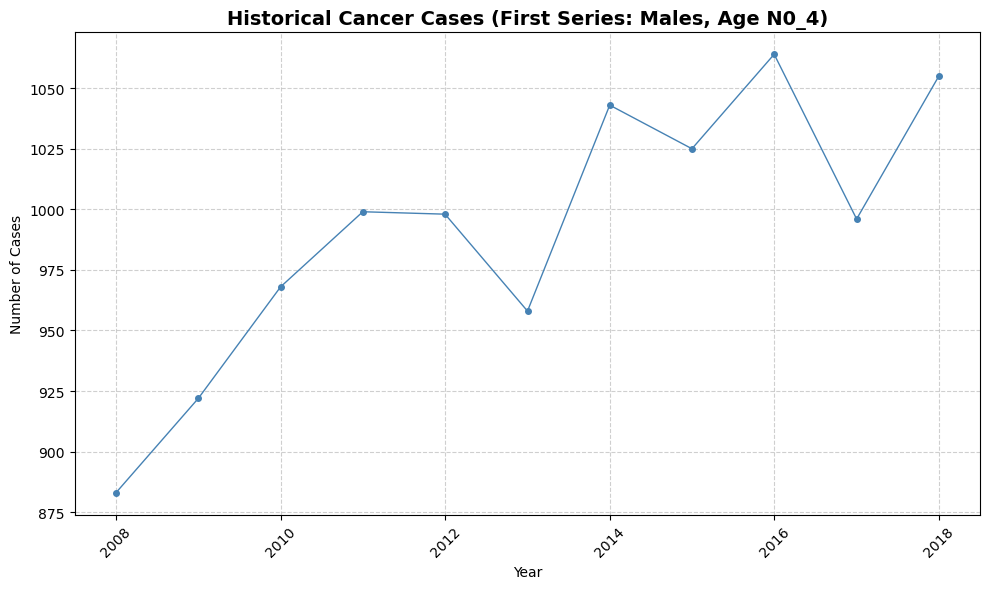


Summary of y:
count      11.000000
mean      991.909091
std        56.086459
min       883.000000
25%       963.000000
50%       998.000000
75%      1034.000000
max      1064.000000
Name: y, dtype: float64

Fitting Prophet model....


18:59:22 - cmdstanpy - INFO - Chain [1] start processing
18:59:22 - cmdstanpy - INFO - Chain [1] done processing


Generating forecasts ...

5-year Forecast
           ds         yhat   yhat_lower   yhat_upper
11 2018-12-31  1076.169175  1016.966068  1130.995397
12 2019-12-31  1090.202218  1032.326837  1140.822840
13 2020-12-31  1104.273707  1041.520998  1164.141699
14 2021-12-31  1118.306750  1058.687988  1181.411144
15 2022-12-31  1132.339792  1070.978110  1192.141495

Forecast with Uncertainty Metrics
           ds    yhat  yhat_lower  yhat_upper  prediction_interval  \
11 2018-12-31  1076.2      1017.0      1131.0                114.0   
12 2019-12-31  1090.2      1032.3      1140.8                108.5   
13 2020-12-31  1104.3      1041.5      1164.1                122.6   
14 2021-12-31  1118.3      1058.7      1181.4                122.7   
15 2022-12-31  1132.3      1071.0      1192.1                121.2   

   relative_uncertainty  
11                10.6%  
12                9.95%  
13                11.1%  
14               10.97%  
15                10.7%  


In [14]:

###############################################################
# This script forecasts the next 5 years of cancer incidence in
# Europe by classification cancer, age group, and sex
###############################################################



print ('--- Subsetting the series ---')
# Select the first unique combination (item_id[0])
serie_df = filtering_item(df_cancer_incidence_2007_2017, item_id.iloc[0]) 

print(serie_df)

# Checking for missing dates and completeness
print(f"Date range: {serie_df['ds'].min()} to {serie_df['ds'].max()}")
print(f"Number of observations: {len(serie_df)}")
print(f"Missing values in y: {serie_df['y'].isnull().sum()}")

#====================================================
# 3. Exploratory Data Analysis --------------------------------------------
#====================================================

# R: ggplot(serie_df, aes(x = ds, y = y)) + geom_line(...) + ...
plt.figure(figsize=(10, 6))
plt.plot(serie_df['ds'], serie_df['y'], color='steelblue', linewidth=1, marker='o', markersize=4)

plt.title("Historical Cancer Cases (First Series: Males, Age N0_4)", fontsize=14, fontweight='bold')
plt.xlabel("Year")
plt.ylabel("Number of Cases")
plt.grid(True, linestyle='--', alpha=0.6)
plt.gca().tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

print("\nSummary of y:")
print(serie_df['y'].describe())

#====================================================
# 4. Prophet model setup
#====================================================

# R: model <- prophet(...)
# Note: Prophet is initialized as 'Prophet()' in Python.
# 'changepoint_prior_scale' is the Python equivalent of 'changepoint.prior.scale'

model = Prophet(
    growth='linear',
    yearly_seasonality=False, # Set to True if you suspect yearly patterns
    weekly_seasonality=False, # False for annual data
    daily_seasonality=False,  # False for annual data
    seasonality_mode='additive',
    changepoint_prior_scale=0.05, # Flexibility of trend (0.001-0.5, default 0.05)
    seasonality_prior_scale=10.0, # Flexibility of seasonality (default 10)
    interval_width=0.95,      # 95% prediction intervals
    uncertainty_samples=1000  # Number of samples for uncertainty estimation
)

# Optional: Add regressors (external variables)
# model.add_regressor('population_size')

#====================================================
# 5. Fit the model --------------------------------------------------------
#====================================================

print("\nFitting Prophet model....")
# R: model <- fit.prophet(model, serie_df)
model.fit(serie_df)


#====================================================
# 6. Generate Forecast -----------------------------------------------------
# Create future dataframe for 5 years (5 observations for annual data)
#====================================================


# R: future <- make_future_dataframe(model, periods = 5, freq = 'year')
# In Python, 'freq' is specified using pandas offset aliases. 'Y' (or 'Y-DEC') works for year-end.
future = model.make_future_dataframe(
    periods=5,
    freq='Y' # Annual frequency, defaulting to year end (Dec 31)
)

# Generate predictions
print("Generating forecasts ...")
# R: forecast <- predict(model, future)
forecast = model.predict(future)

#====================================================
# 7. Examine Results ------------------------------------------------------
#====================================================


# R: future_forecast <- forecast %>% tail(5) %>% select(ds, yhat, yhat_lower, yhat_upper)
future_forecast = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(5).copy()

print("\n5-year Forecast")
print(future_forecast)

# R: future_forecast %>% mutate(prediction_interval = ..., relative_uncertainty = ...)
future_forecast['prediction_interval'] = future_forecast['yhat_upper'] - future_forecast['yhat_lower']
# Ensure 'yhat' is not zero before dividing
future_forecast['relative_uncertainty'] = np.where(
    future_forecast['yhat'] != 0,
    (future_forecast['yhat_upper'] - future_forecast['yhat_lower']) / future_forecast['yhat'] * 100,
    np.nan
)


print("\nForecast with Uncertainty Metrics")
# Format output for cleaner printing
future_forecast_display = future_forecast.copy()
future_forecast_display['yhat'] = future_forecast_display['yhat'].round(1)
future_forecast_display['yhat_lower'] = future_forecast_display['yhat_lower'].round(1)
future_forecast_display['yhat_upper'] = future_forecast_display['yhat_upper'].round(1)
future_forecast_display['prediction_interval'] = future_forecast_display['prediction_interval'].round(1)
future_forecast_display['relative_uncertainty'] = future_forecast_display['relative_uncertainty'].round(2).astype(str) + '%'

print(future_forecast_display)




# Visualización del pronóstico

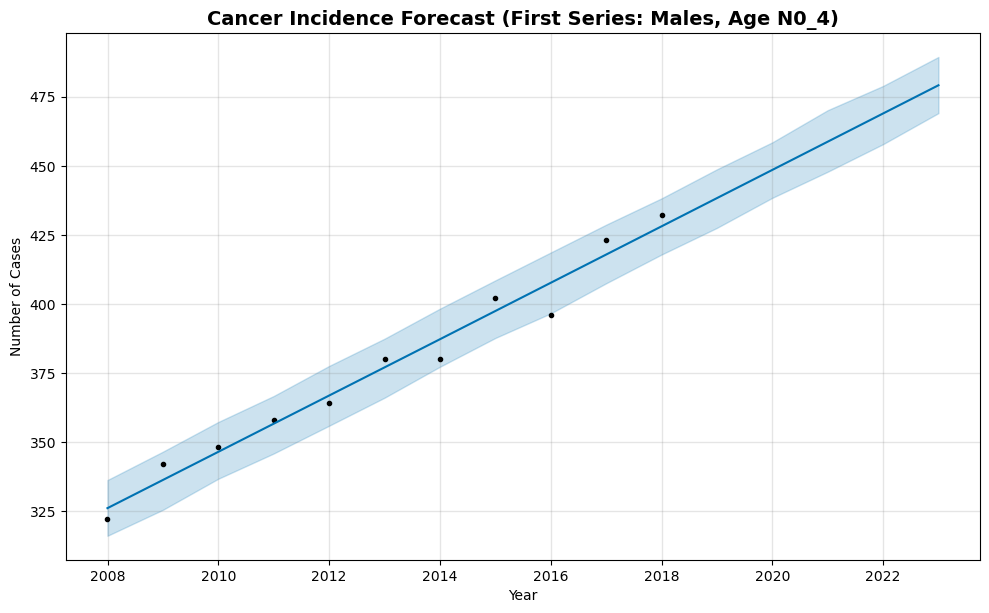

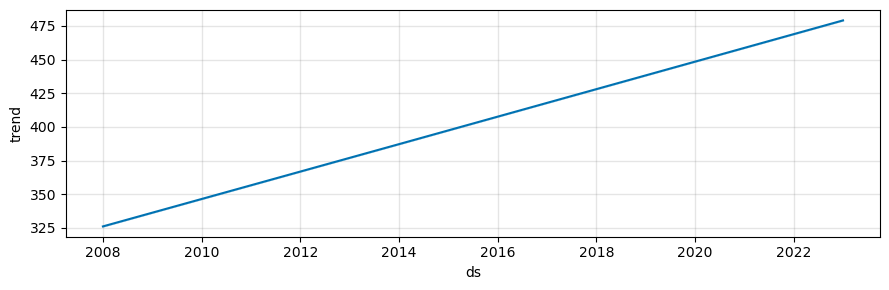

In [13]:
#====================================================
# 8. Visualization --------------------------------------------------------
#====================================================

# Plot 1: Forecast with components
# R: plot(model, forecast)
fig1 = model.plot(forecast)
fig1.gca().set_title("Cancer Incidence Forecast (First Series: Males, Age N0_4)", fontsize=14, fontweight='bold')
fig1.gca().set_xlabel("Year")
fig1.gca().set_ylabel("Number of Cases")
plt.show()

# Plot 2: Decomposition (trend, seasonality if applicable)
# R: prophet_plot_components(model, forecast)
fig2 = model.plot_components(forecast)
plt.show()